In [5]:
import torch
import math
from einops import repeat
import torch.nn as nn


In [6]:
import numpy as np
def hippo_LegS_1(n):
    #will return the hippo-legs matrix used in s4
    A = np.zeros((n,n))
    B = np.array([math.sqrt(2*i+1) for i in range(n)]).reshape(-1,1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A[i,j] = -(i+1)
            if i < j:
                A[i,j] = 0
            if i > j:
                A[i,j] = -math.sqrt((2*i+1)*(2*j+1))
    return A,B

def hippo_LegS_dplr(n):
    #returns the diagonal-plus-low-rank matrix 
    A_n = np.zeros((n,n))
    P = np.array([math.sqrt(i+1/2) for i in range(n)]).reshape(-1,1)
    for i in range(n):
        for j in range(n):
            if i == j:
                A_n[i,j] = -1/2
            else:
                A_n[i,j] = -math.sqrt((i+1/2)*(j+1/2))
    PPT = P @ P.T
    A = A_n - PPT
    A_d = np.linalg.eigvals(A)
    return A, A_d

def zero_order_hold(A,B,dt):
    da = np.exp(A * dt)
    db = np.dot(np.linalg.inv(A * dt) * (da - np.identity(A.shape[0])), dt*B)
    return da, db

def bilinear(A,B,dt):
    id = np.identity(A.shape[0])
    inv = np.linalg.inv(id - dt * A / 2)
    da = inv @ (id + dt * A / 2)
    db = inv @ B * dt
    return da, db

A,B = hippo_LegS_1(5)
A1,A1_d = hippo_LegS_dplr(5)
print(A)
print(A1)
print(A1_d)

da,db = zero_order_hold(A,B,0.1)
da1,db1 = bilinear(A,B,0.1)


[[-1.          0.          0.          0.          0.        ]
 [-1.73205081 -2.          0.          0.          0.        ]
 [-2.23606798 -3.87298335 -3.          0.          0.        ]
 [-2.64575131 -4.58257569 -5.91607978 -4.          0.        ]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.        ]]
[[-1.         -1.73205081 -2.23606798 -2.64575131 -3.        ]
 [-1.73205081 -2.         -3.87298335 -4.58257569 -5.19615242]
 [-2.23606798 -3.87298335 -3.         -5.91607978 -6.70820393]
 [-2.64575131 -4.58257569 -5.91607978 -4.         -7.93725393]
 [-3.         -5.19615242 -6.70820393 -7.93725393 -5.        ]]
[-22.25614697   0.10302733   3.52700511   2.37838424   1.24773029]


In [8]:
from einops import einsum
#numpy versions of the code
def discretize(log_dt,log_A_real,A_imag,B):
    #update this to be n-dimensional
    
    dt, A = np.exp(log_dt), -np.exp(log_A_real) + 1j * A_imag

    dtA = einsum(dt,A, 'n, n h -> n h')
    dtB = einsum(dt,B, 'n, n h -> n h')

    dA = (1 + dtA / 2) / (1 - dtA / 2)
    dB = dtB / (1 - dtA/2)

    # dA, dB = (1+dt * A/2) / (1 - dt * A/2), dt * B / (1 - dt * A/2)

    return dA, dB

def nd_s4d(n_inputs,n_states_per_input,dt_min=1e-3,dt_max=1e-1):

    log_dt = np.random.rand(n_inputs) * (np.log(dt_max) - np.log(dt_min)) + np.log(dt_min)
    A = -0.5 + 1j * np.pi * np.arange(n_states_per_input//2)
    A = np.concatenate([A,np.conj(A[::-1])])
    #repeat this across a new dimension for each input
    A = np.repeat(A[np.newaxis,:], n_inputs, axis=0)
    B = np.ones((n_inputs,n_states_per_input)) + 0j
    C = np.random.randn(n_inputs,n_states_per_input) + 1j * np.random.randn(n_inputs,n_states_per_input)
    
    return log_dt, np.log(-A.real), A.imag, B, C


def forward_nd(us,dA,dB,C):
    #num_dimensions is the number of dimensions in the input
    #num_states is the number of dimensions of the SSM per each input
    #us has input (num_dimensions, time (L))
    #dA has shape (num_dimensions, num_states) (diagonal)
    #dB has shape (num_dimensions, num_states)
    #C has shape (num_dimensions, num_states, 1)
    L = us.shape[-1]
    xs = np.zeros((*dA.shape,L),dtype=np.complex128) #num_dimensions, num_states, time
    ys = np.zeros((us.shape[0],L),dtype=np.complex128) #num_dimensions, time)
    inp = einsum(dB,us,'d n, d t -> d n t')
    for i in range(L):
        xs[:,:,i] = dA * xs[:,:,i-1] + inp[:,:,i]
        ys[:,i] = einsum(C,xs[:,:,i],'d n, d n -> d')
    
    return xs, ys.real
    

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from einops import einsum,repeat
import math
import torch

class S4D_rnn(nn.Module):
    #this computes an s4d model 
    def __init__(self,n_inputs,n_states_per_input,dt_min=1e-3,dt_max=1e-1,seed=None,lr=None):
        super().__init__()
        if seed is not None:
            torch.random.seed(seed)

        log_dt = torch.rand(n_inputs) * (math.log(dt_max) - math.log(dt_min)) + np.log(dt_min)
        self.register("log_dt",log_dt,lr)
        
        log_A_real = torch.log(0.5 * torch.ones(n_inputs, n_states_per_input // 2))
        A_imag = math.pi * repeat(torch.arange(n_states_per_input//2), 'n -> h n', h=n_inputs)

        self.register("log_A_real", log_A_real, lr)
        self.register("A_imag", A_imag, lr)

        B = torch.ones((n_inputs,n_states_per_input)) + 0j
        self.register("B",B,lr)

        C = torch.rand(n_inputs,n_states_per_input // 2) + 1j * torch.rand(n_inputs,n_states_per_input // 2)
        self.register("C",C,lr)

    def discretize(self,log_dt,log_A_real,A_imag,B):
    
        dt, A = torch.exp(log_dt), -torch.exp(log_A_real) + 1j * A_imag

        dtA = einsum(dt,A, 'n, n h -> n h')
        dtB = einsum(dt,B, 'n, n h -> n h')

        dA = (1 + dtA / 2) / (1 - dtA / 2)
        dB = dtB / (1 - dtA/2)

        return dA, dB

    def register(self, name, tensor, lr=None):
        """Register a tensor with a configurable learning rate and 0 weight decay"""

        if lr == 0.0:
            self.register_buffer(name, tensor)
        else:
            self.register_parameter(name, nn.Parameter(tensor))

            optim = {"weight_decay": 0.0}
            if lr is not None: optim["lr"] = lr
            setattr(getattr(self, name), "_optim", optim)

    def forward(self,us,rnn=True):
        #num_dimensions is the number of dimensions in the input
        #num_states is the number of dimensions of the SSM per each input
        #us has input (num_dimensions, time (L)) or (batch, num_dim, time)
        #dA has shape (num_dimensions, num_states) (diagonal)
        #dB has shape (num_dimensions, num_states)
        #C has shape (num_dimensions, num_states, 1)
        if len(us.shape) == 2:
            us = us.unsqueeze(0)

        b,nd,L = us.shape
        device = us.device
        #expand A_imag and log_A_real to include complex conjugates (do here so weights are tied)
        A_imag = torch.cat([self.A_imag, -self.A_imag], dim=1)
        #double log_A_real to match
        log_A_real = torch.cat([self.log_A_real, self.log_A_real], dim=1)

        dA, dB = self.discretize(self.log_dt, log_A_real, A_imag, self.B)

        nstates = dA.shape[-1]
        L = us.shape[-1]

        if rnn:
            C = torch.cat([self.C, self.C], dim=1)
            # xs = torch.zeros((b, nd, nstates, L),dtype=torch.complex64) #num_dimensions, num_states, time
            xs = torch.zeros((b, nd,nstates),dtype=torch.complex64).to(device) #num_dimensions, num_states, time
            all_xs = [xs]
            ys = torch.zeros((b, nd, L), dtype=torch.complex64).to(device) #num_dimensions, time)
            inp = einsum(dB,us,'d n, b d t -> b d n t')
            for i in range(L):
                xs = einsum(dA, xs, 'd n, b d n -> b d n') + inp[:,:,:,i]
                all_xs.append(torch.clone(xs))
                ys[:,:,i] = einsum(C,xs,'d n, b d n -> b d')
            
            all_xs = torch.stack(all_xs,dim=-1)

            return all_xs, ys.real

        else:
            #compute the kernel, then convolve
            dt = torch.exp(self.log_dt) # (H)
            # C = torch.view_as_complex(self.C) # (H N)
            C = self.C
            A = -torch.exp(self.log_A_real) + 1j * self.A_imag # (H N)

            # Vandermonde multiplication
            dtA = A * dt.unsqueeze(-1)  # (H N)
            K = dtA.unsqueeze(-1) * torch.arange(L, device=A.device) # (H N L)
            print(dtA.shape,A.shape,C.shape)
            C = C * (torch.exp(dtA)-1.) / A
            #no multiplying by 2 here because we plugged in the conjugate
            k = 2 * torch.einsum('hn, hnl -> hl', C, torch.exp(K)).real

            # Convolution
            k_f = torch.fft.rfft(k, n=2*L) # (H L)
            u_f = torch.fft.rfft(us, n=2*L) # (B H L)
            y = torch.fft.irfft(u_f*k_f, n=2*L)[..., :L] # (B H L)


            return None, y


(2, 4)
[[0.98122582+0.j         0.97435754+0.11644925j 0.97435754-0.11644925j
  0.98122582+0.j        ]
 [0.99637871+0.j         0.99612036+0.02270907j 0.99612036-0.02270907j
  0.99637871+0.j        ]]
(2, 4, 1000) (2, 1000)


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


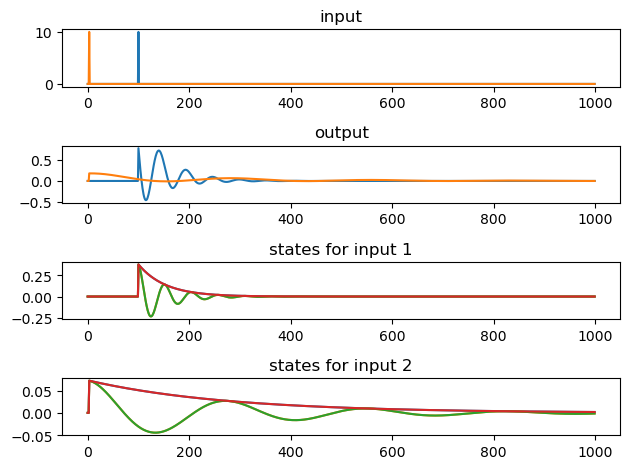

In [58]:
n_inps = 2
log_dts, log_A_reals, A_imags, Bs, Cs = nd_s4d(n_inps,4)
print(Cs.shape)
dA, dB = discretize(log_dts,log_A_reals,A_imags,Bs)
print(dA)
L = 1000
u = np.zeros((n_inps,L))
u[0,100:101] = 10
u[1,3:4] = 10

xs, ys = forward_nd(u,dA,dB,Cs)
print(xs.shape,ys.shape)

def plot_uxy(u,xs,ys):
    if xs is not None:
        fig,ax = plt.subplots(4,1)
    else:
        fig, ax = plt.subplots(2,1)
    ax[0].plot(u.T)
    ax[0].set_title("input")
    ax[1].plot(ys.T)
    ax[1].set_title("output")
    if xs is not None:
        ax[2].set_title("states for input 1")
        ax[2].plot(xs[0].T)
        ax[3].set_title("states for input 2")
        ax[3].plot(xs[1].T)
    plt.tight_layout()

plot_uxy(u,xs,ys)

(2, 1000)


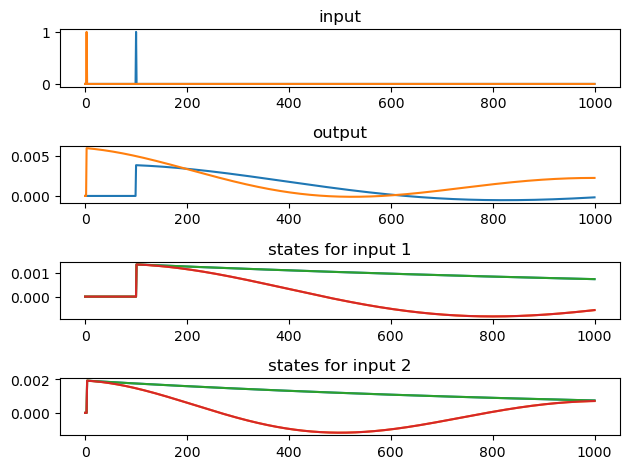

In [59]:
L = 1000
n_inps = 2
u = torch.zeros((n_inps,L))
u[0,100:101] = 1
u[1,3:4] = 1

s4d = S4D_rnn(n_inputs=n_inps,n_states_per_input=4)

xs, ys = s4d(u,rnn=True)

u = u.detach().numpy()
if xs is not None:
    xs = xs.detach().numpy().squeeze()
ys = ys.detach().numpy().squeeze()

print(ys.shape)
plot_uxy(u,xs,ys)

In [63]:
class S4DMinimal(nn.Module):
    def __init__(self,d_input,d_output,d_model,d_state,dropout=0.0,prenorm=False):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input,d_model)
        self.s4 = S4D_rnn(n_inputs=d_model,n_states_per_input=d_state)

        self.decoder = nn.Linear(d_model,d_output)
        self.norm = nn.LayerNorm(d_model)
        self.droppout = nn.Dropout(dropout)

        self.mlp = nn.Sequential(
            nn.Linear(d_model,4*d_model),
            nn.ReLU(),
            nn.Linear(4*d_model,d_output)
        )

        self.rnn = False

    def forward(self,x):
        u = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
         
        u = u.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)

        if self.prenorm:
            # Prenorm
            u = self.norm(u.transpose(-1, -2)).transpose(-1, -2)

        # Apply S4 block: we ignore the state input and output
        xs, ys = self.s4(u,rnn = self.rnn)
        self.ssm_states = xs
        self.ssm_outs = ys

        ys = ys.transpose(-1, -2)  # (B, d_model, L) -> (B, L, d_model)
        u = u.transpose(-1, -2)
        # Residual connection
        zs = ys + u # B, L, d_model

        if not self.prenorm:
            # Postnorm
            zs = self.norm(zs)

        # zs = zs.transpose(-1, -2) # B, d_model, L

        # Decode the outputs
        zs = self.mlp(zs)  # (B, L, d_model) -> (B, L, d_output)

        return zs, xs

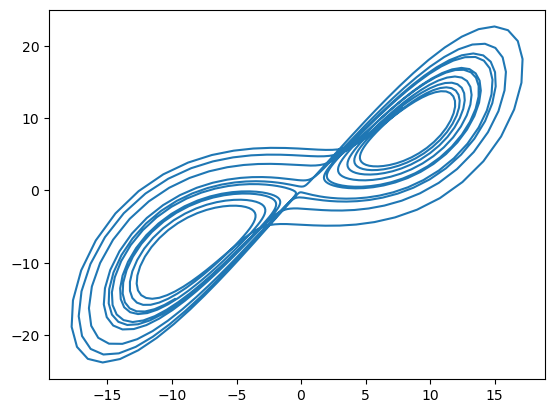

In [14]:
from dysts.flows import Lorenz, Hadley

## Load and simulate an attractor
model = Lorenz()
sol = model.make_trajectory(1000, resample=True,noise=0.00)
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])


In [61]:
from utils import make_dataset,train

train_loader, val_loader, train_data, val_data = make_dataset(Lorenz,500,10)


(10, 500, 3) torch.Size([10, 500, 1])
(10, 500, 3) torch.Size([10, 500, 1])


In [65]:
data = next(iter(train_loader))
model = S4DMinimal(1,1,4,10)
model.rnn = True
out,hiddens = model(data)

print(data.shape,out.shape)
print(hiddens.shape)

torch.Size([1, 500, 1]) torch.Size([1, 500, 1]) torch.Size([1, 4, 10, 501])


/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/om2/user/ostrow/anaconda/envs/nn_delays/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


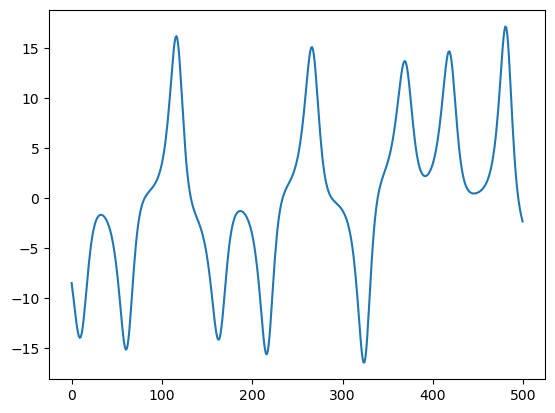

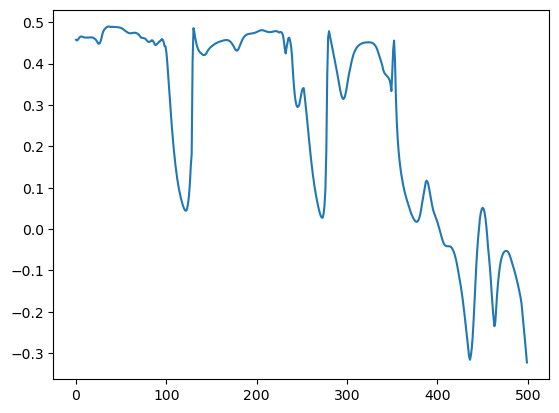

In [66]:
plt.plot(data[0,:,0])
plt.figure()
plt.plot(out[0,:,0].detach().numpy())

fig, ax = plt.subplots(hiddens.shape[1],hiddens.shape[2],figsize=(20,20))
for i in range(hiddens.shape[1]):
    for j in range(hiddens.shape[2]):
        ax[i,j].plot(hiddens[0,i,j].detach().numpy())

plt.tight_layout()

In [56]:
from torch.optim import AdamW

model = S4DMinimal(1,1,4,10)
#model,train_set,val_set,epochs,lr,optimizer,loss_fn,device
all_train_loss = []
all_val_loss = []
for num_steps in [1,3]:
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-2,AdamW, nn.MSELoss(), 'cuda',num_steps)
    model, train_loss, val_loss = train(model, train_loader, val_loader, 50, 1e-3,AdamW, nn.MSELoss(), 'cuda',num_steps)
    all_train_loss.extend(train_loss)
    all_val_loss.extend(val_loss)

plt.plot(all_train_loss)
plt.plot(all_val_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: 'bool' object is not callable